Note to myself: Runs with `degas2` env. There are no special needs for this environment. Just the following python packages are needed.

In [1]:
import sys
sys.path.insert(0, "/users/hasanm4/lore/wsources/DEGAS2-XGC/degas2/scripts/")
from genmesh import get_triangulation, gen_cones, populate_edge_map, orient_surfaces
import numpy as np
from tqdm import tqdm
from polygon import Vertex, Polygon, find_next_wall_node
import matplotlib.tri as mtri
import matplotlib.pyplot as plt
import netCDF4 as nc

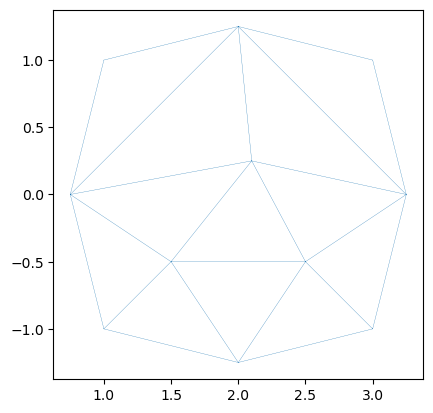

In [3]:
triang,rz,conn=get_triangulation("minDG2Mesh")
#triang,rz,conn=get_triangulation("highres/PFPO")
edges_orig=triang.edges
Nedge_orig=len(edges_orig[:,0])
Nplasma=len(conn[:,0])
Nnode = len(rz[:,0])
plt.triplot(triang,linewidth=0.2)
plt.gca().set_aspect("equal")

In [4]:
edgemap_orig=-1*np.ones([Nplasma,3],dtype=int)
def intpairing(a,b):
    return (a+b)*(a+b+1)/2 + a
conn_sort = np.sort(conn,axis=1)
edge1_c=intpairing(conn_sort[:,1],conn_sort[:,0])
edge2_c=intpairing(conn_sort[:,2],conn_sort[:,0])
edge3_c=intpairing(conn_sort[:,2],conn_sort[:,1])
edges_c=intpairing(edges_orig[:,0],edges_orig[:,1])
for i in tqdm(range(0,Nplasma)):
    edgemap_orig[i,0] = np.argwhere(np.equal(edge1_c[i],edges_c))[0][0]
    edgemap_orig[i,1] = np.argwhere(np.equal(edge2_c[i],edges_c))[0][0]
    edgemap_orig[i,2] = np.argwhere(np.equal(edge3_c[i],edges_c))[0][0]
edgemap_rev_orig = -1*np.ones([Nedge_orig,2],dtype=int)
for i in tqdm(range(0,Nedge_orig)):
    # Finds triangle for which this is the jth edge
    tri_idx = np.nonzero(np.logical_or(np.equal(edges_c[i],edge3_c),np.logical_or(np.equal(edges_c[i],edge1_c),np.equal(edges_c[i],edge2_c))))
    if np.size(tri_idx) == 0:
        print("ERROR: could not find a triangle for this edge.")
    elif np.size(tri_idx) > 2:
        print("ERROR: an edge cannot have more than 2 adjacent triangles")
    elif (np.size(tri_idx) == 1):
        edgemap_rev_orig[i,0] = tri_idx[0]
    else:
        edgemap_rev_orig[i,:] = np.array(tri_idx)
    

  0%|                                                                                            | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_919610/4159133774.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  edgemap_rev_orig[i,0] = tri_idx[0]
100%|████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 49824.35it/s]


In [5]:
np.count_nonzero(edgemap_rev_orig[:,0]==-1)

np.int64(0)

In [6]:
unique,counts = np.unique(edgemap_orig,return_counts=True)
# Indices are flattened
Nwall = np.count_nonzero(counts == 1)
wall_edges = edges_orig[unique[np.where(counts == 1)],:]
startidx = np.argmin(rz[:,0]**2+rz[:,1]**2)

vertices=[]
wallvertices=[]
for i in range(0,Nnode):
    vertices.append(Vertex(i,rz[i,0],rz[i,1]))
    if np.isin(i,wall_edges):
        vertices[-1].wall = True
        wallvertices.append(vertices[-1])
Nwall=len(wallvertices)
polys=[]
wallpolys=[]
for i in range(0,Nplasma):
    poly=Polygon()
    poly.add_vertex(vertices[conn[i,0]])
    poly.add_vertex(vertices[conn[i,1]])
    poly.add_vertex(vertices[conn[i,2]])
    polys.append(poly)
    if np.isin(vertices[conn[i,0]].id,wall_edges) or np.isin(vertices[conn[i,1]].id,wall_edges) or np.isin(vertices[conn[i,2]].id,wall_edges):
        wallpolys.append(polys[-1])

wallvertices_ordered = np.zeros(Nwall,dtype=int)
wallvertices_ordered[0] = startidx
current_node = vertices[startidx]
prev_node = -1
first = True
for i in tqdm(range(0,Nwall-1)):
    next_node = find_next_wall_node(current_node,prev_node,wallvertices,wallpolys,first)
    first=False
    wallvertices_ordered[i+1] = next_node.id
    prev_node = current_node
    current_node = next_node



100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1950.71it/s]


[1. 1.] [2.   1.25]


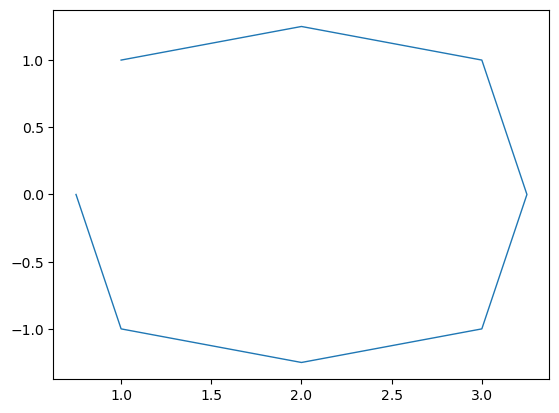

In [7]:
wallpoly=Polygon()
for i in range(0,Nwall):
    wallpoly.add_vertex(vertices[wallvertices_ordered[i]])
if not wallpoly.is_clockwise():
    wallvertices_ordered = wallvertices_ordered[::-1]
print(rz[wallvertices_ordered[0],:],rz[wallvertices_ordered[1],:])
plt.plot(rz[wallvertices_ordered[:],0],rz[wallvertices_ordered[:],1],"-",linewidth=1)

/tmp/ipykernel_919610/741242717.py:15: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  convex = np.sign(np.cross(v2,v1))


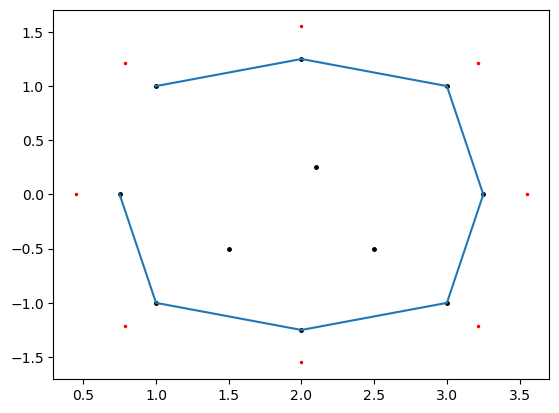

In [8]:
rz_all = np.zeros([Nnode+Nwall,2])
conn_all = np.zeros([Nplasma+Nwall*2,3],dtype=int)
rz_all[0:Nnode,:] = rz
conn_all[0:Nplasma,:] = conn
thickness = 0.3
eps = 1e-3
# Add new nodes:
for i in range(0,Nwall):
    i_p1 = (i+1)%Nwall
    i_m1 = (i-1)%Nwall
    v1 = rz[wallvertices_ordered[i_p1],:] - rz[wallvertices_ordered[i],:]
    v2 = rz[wallvertices_ordered[i_m1],:] - rz[wallvertices_ordered[i],:]
    v1 = v1/np.linalg.norm(v1)
    v2 = v2/np.linalg.norm(v2)
    convex = np.sign(np.cross(v2,v1))
    if (np.linalg.norm(v1+v2) < eps):
        # Nodes are colinear, just take the perpendicular
        outer = thickness*np.array([-v1[1],v1[0]])
    else:
        outer = -convex*thickness*(v1+v2)/np.linalg.norm(v1+v2)
    #print(wallvertices_ordered[i_p1],wallvertices_ordered[i],wallvertices_ordered[i_m1])
    #print(outer)
    rz_all[Nnode+i,:] = rz[wallvertices_ordered[i],:]+outer
    #print(rz_all[Nnode+i,:])
plt.plot(rz_all[:,0],rz_all[:,1],".",markersize=3,color="r")
plt.plot(rz[:,0],rz[:,1],".",markersize=5.0,color="k")
plt.plot(rz[wallvertices_ordered[:],0],rz[wallvertices_ordered[:],1],"-")
#plt.xlim([4.6,4.8])
#plt.ylim([-3.8,-3.6])
#np.argwhere(rz_all[:,0] < 0.1)

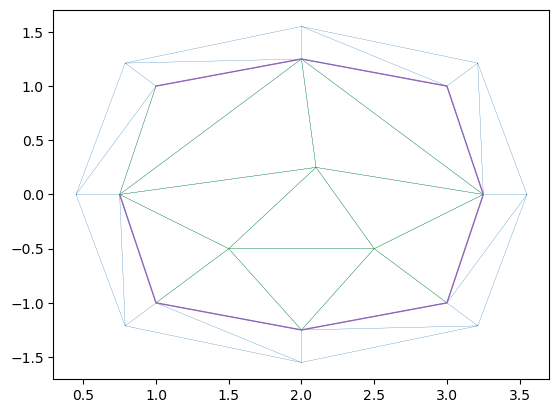

In [9]:
for i in range(0,Nwall):
    i_p1 = (i+1)%Nwall
    i_m1 = (i-1)%Nwall
    conn_all[Nplasma+i,:] = [wallvertices_ordered[i_p1],wallvertices_ordered[i],Nnode+i]
    conn_all[Nplasma+Nwall+i,:] = [Nnode+i,Nnode+i_p1,wallvertices_ordered[i_p1]]
triang_all=mtri.Triangulation(rz_all[:,0],rz_all[:,1],conn_all)
plt.triplot(triang_all,linewidth=0.2)
plt.triplot(triang,linewidth=0.25)
plt.plot(rz[wallvertices_ordered[:],0],rz[wallvertices_ordered[:],1],"-",linewidth=1)
#plt.xlim([4.0,5.0])
#plt.ylim([-4,-3])

In [10]:
import pickle

def save_triangulation(triang, filename):
    """
    Save a matplotlib.tri.Triangulation object to a file.
    
    Parameters:
    -----------
    triang : matplotlib.tri.Triangulation
        The triangulation object to save
    filename : str
        Path to the output file (e.g., 'mesh.tri' or 'mesh.pkl')
    """
    data = {
        'x': triang.x,
        'y': triang.y,
        'triangles': triang.triangles,
        'mask': triang.mask if triang.mask is not None else None
    }
    
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
    
    print(f"Triangulation saved to {filename}")

In [11]:
save_triangulation(triang_all, "minDG2wWall.pkl")

Triangulation saved to minDG2wWall.pkl


In [12]:
Ntri = Nplasma + 2*Nwall
Nnode = Nnode + Nwall
Nedge = Nedge_orig + 3*Nwall
Nsurf_tot = Nedge + 2*Ntri
rz = rz_all
conn = conn_all
triang = triang_all

In [13]:
edges = np.zeros([Nedge_orig+3*Nwall,2],dtype=int)
edgemap = np.zeros([Ntri,3],dtype=int)
edgemap_rev = -1*np.ones([Nedge,2],dtype=int)

edges[0:Nedge_orig] = np.copy(edges_orig)
edgemap[0:Nplasma,:] = np.copy(edgemap_orig)
edgemap_rev[0:Nedge_orig,:] = np.copy(edgemap_rev_orig)
ucell_edges = np.zeros(Nwall,dtype=int)
for i in tqdm(range(0,Nwall)):
    # Consistent with triangle definitions above
    edges[Nedge_orig+3*i,:] = conn[Nplasma+i,[0,2]]                 # diagonal
    edges[Nedge_orig+3*i+1,:] = conn[Nplasma+i,[1,2]]               # transverse connection
    edges[Nedge_orig+3*i+2,:] = conn[Nplasma+Nwall+i,[0,1]]         # universal cell edge
    # Follow same convention with highest node indices first
    edges[Nedge_orig+3*i,:] = [max(edges[Nedge_orig+3*i,:]),min(edges[Nedge_orig+3*i,:])]
    edges[Nedge_orig+3*i+1,:] = [max(edges[Nedge_orig+3*i+1,:]),min(edges[Nedge_orig+3*i+1,:])]
    edges[Nedge_orig+3*i+2,:] = [max(edges[Nedge_orig+3*i+2,:]),min(edges[Nedge_orig+3*i+2,:])]
    # Populate edgemap with the new triangles
    # 
    # First edge is the wall segment, already populated in edgemap_orig and needs to be found
    # others are defined above with reference to triangle definitions
    v1 = max(conn[Nplasma+i,[0,1]])
    v2 = min(conn[Nplasma+i,[0,1]])
    edge1_c=intpairing(v1,v2)
    wallsegment = np.argwhere(np.equal(edge1_c,edges_c))[0][0]
    edgemap[Nplasma+i,0] = wallsegment                                      # wall segment
    edgemap[Nplasma+i,1] = Nedge_orig+3*i+1                                 # transverse connection
    edgemap[Nplasma+i,2] = Nedge_orig+3*i                                   # diagonal
    # The second triangle is embedded entirely in the wall
    edgemap[Nplasma+Nwall+i,0] = Nedge_orig+3*i              # diagonal
    edgemap[Nplasma+Nwall+i,1] = Nedge_orig+3*(i+1)%Nwall+1  # next transverse connection
    edgemap[Nplasma+Nwall+i,2] = Nedge_orig+3*i+2            # universal cell edge
    ucell_edges[i] = Nedge_orig+3*i+2
    if not (edgemap_rev[wallsegment,1] == -1):
        print("ERROR: expected this to be a wall segment with no other triangle originally adjacent to it.")
    # Maps news edges to new and old triangles
    # Find the triangle adjacent to the old outer edge
    edgemap_rev[wallsegment,1] = Nplasma+i
    # The two triangles created that are adjacent to the new diagonal
    edgemap_rev[Nedge_orig+3*i,0] = Nplasma+i
    edgemap_rev[Nedge_orig+3*i,1] = Nplasma+Nwall+i
    # The transverse connection bounds the triangle before it
    edgemap_rev[Nedge_orig+3*i+1,0] = Nplasma+i
    edgemap_rev[Nedge_orig+3*i+1,1] = Nplasma+Nwall+(i-1)%Nwall
    # Finally, the new universal cell edge
    edgemap_rev[Nedge_orig+3*i+2,0] = Nplasma+Nwall+i-1
    

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 9631.01it/s]


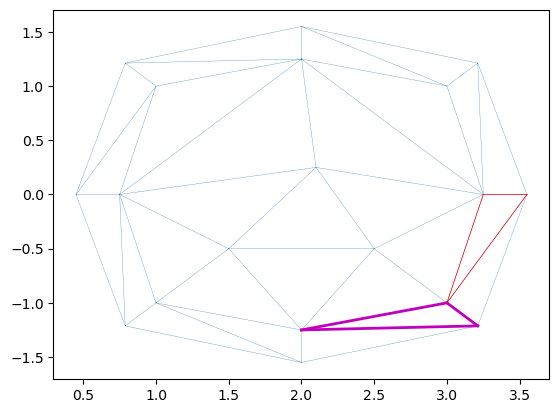

In [14]:
# These should all plot a triangle within the wall
for i in range(0,3):
    plt.plot(rz[edges[edgemap[Nplasma+4,i],:],0],rz[edges[edgemap[Nplasma+4,i],:],1],linewidth=2,color="m")
    plt.plot(rz[conn[Nplasma+3,[i,(i+1)%3]],0],rz[conn[Nplasma+3,[i,(i+1)%3]],1],linewidth=.5,color="r")
plt.triplot(triang_all,linewidth=0.2)

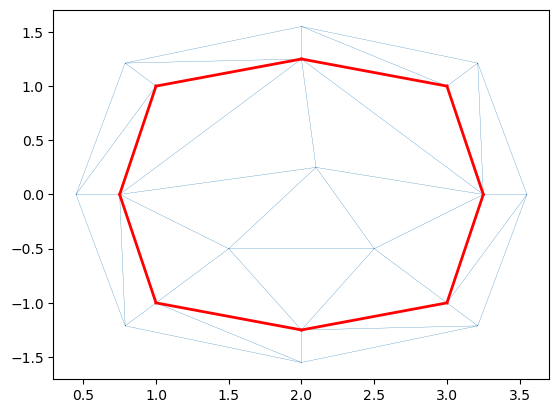

In [15]:
# This should plot the wall segments
walledges = edgemap[Nplasma:Nplasma+Nwall,0]
for i in range(0,Nwall):
    plt.plot(rz[edges[walledges[i],:],0],rz[edges[walledges[i],:],1],color="r",linewidth=2)
plt.triplot(triang_all,linewidth=0.2)
#plt.xlim([4.0,4.5])
#plt.ylim([-.5,.5])

In [16]:
surface_coeffs = np.zeros([Nsurf_tot,10])
surface_coeffs[0:Nedge,:] = gen_cones(rz[edges[:,0],:],rz[edges[:,1],:])

In [17]:
for i in tqdm(range(0,Ntri)):
    # These are just planes defined by z-Z0=0
    zmin=np.min(rz[conn[i,:],1])
    zmax=np.min(rz[conn[i,:],1])
    surface_coeffs[Nedge+2*i,:] = [-zmin,0,0,1.0,0,0,0,0,0,0]
    surface_coeffs[Nedge+2*i+1,:] = [zmax,0,0,-1.0,0,0,0,0,0,0]
    # Cut surfaces don't seem to have surface_points defined
#    surface_points[Nedge+2*i,0,:] = [np.min(rz[conn[i,:],0]), 0.0,zmin]
#    surface_points[Nedge+2*i,1,:] = [np.max(rz[conn[i,:],0]), 0.0,zmin]
#    surface_points[Nedge+2*i+1,0,:] = [np.min(rz[conn[i,:],0]), 0.0,zmax]
#    surface_points[Nedge+2*i+1,1,:] = [np.max(rz[conn[i,:],0]), 0.0,zmax]
    

100%|████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 83528.10it/s]


In [18]:
ncells = Ntri+2*Nwall
cells = np.zeros([ncells+1,4],dtype=int)
cells[0,0:4] = [1,Nwall,Nwall,0]

cells[1:Ntri+1,0] = 1+Nwall+5*np.array(range(0,Ntri),dtype=int)
cells[1:Ntri+1,1] = 3
cells[1:Ntri+1,2] = 5

cells[1:Nplasma+1,3] = np.array(range(1,Nplasma+1),dtype=int)
cells[Nplasma+1:,3] = Nplasma+1

nboundaries = Nwall+5*Ntri
boundaries = np.zeros(nboundaries,dtype=int)
# TODO: Set the signs of the universal cell boundaries correctly 
# and set the first Nwall elements of boundaries accordingly
centroids = np.average(rz[conn[:,:],:],axis=1)
print(np.shape(centroids))
surf_signs = np.zeros_like(edgemap,dtype=int)
for i in tqdm(range(0,Ntri)):
#    surf_signs[i,:] = np.where((centroids[i,1]-lines_intercept[edgemap[i,:]])/lines_slope[edgemap[i,:]] > centroids[i,0],[-1,-1,-1],[1,1,1])
    surf_signs[i,:] = orient_surfaces(surface_coeffs[edgemap[i,:],:], np.array(centroids[i,:],ndmin=2))
#edgemap = surf_signs*edgemap

(28, 2)


100%|████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 11993.52it/s]


array([-1,  1, -1])

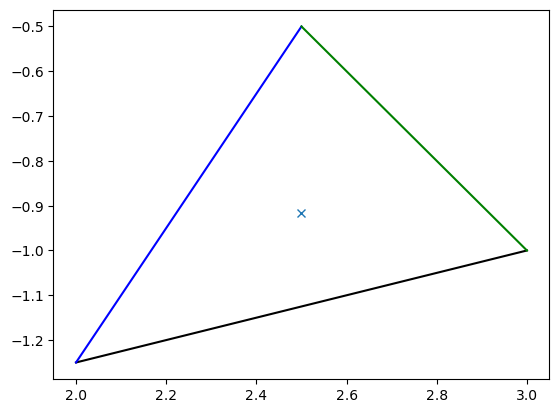

In [19]:
itri=2
localedges = edgemap[itri,:]
rs = np.zeros([3,2])
zs = np.zeros([3,2])
for j in range(0,3):
    rs[j,:] = rz[edges[localedges[j],:],0]
    zs[j,:] = rz[edges[localedges[j],:],1]
plt.plot(centroids[itri,0],centroids[itri,1],"x")
plt.plot(rs[0,:],zs[0,:],"-k")
plt.plot(rs[1,:],zs[1,:],"-b")
plt.plot(rs[2,:],zs[2,:],"-g")
surf_signs[itri,:]

In [20]:
np.any( np.logical_or( np.isnan(surf_signs), np.isinf(surf_signs)) )

np.False_

In [21]:
for i in tqdm(range(1,Ntri+1)):
    bdy_start = Nwall+(i-1)*5
    cut_start = Nedge+2*(i-1)

    boundaries[bdy_start:bdy_start+3] = surf_signs[i-1,:]*(edgemap[i-1,:] + 1)
    boundaries[bdy_start+3:bdy_start+5] = [cut_start+1,cut_start+2]

100%|███████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 102927.71it/s]


In [22]:
centroid = np.average(rz[:,:],axis=1)
ucell_signs = np.zeros(Nwall,dtype=int)
for i in range(0,Nwall):
    ucell_signs[i] = orient_surfaces(np.array(surface_coeffs[i,:],ndmin=2),np.array(centroid[:],ndmin=2))[0]
    boundaries[i] = ucell_signs[i]*(i+1)

In [23]:
boundaries[0:Nwall] = boundaries[1+Nplasma+Nwall:1+Nplasma+2*Nwall]

In [24]:
onlyfaces = boundaries[abs(boundaries)<Nwall+3*Ntri]
np.count_nonzero( np.abs(onlyfaces) == 2)

np.int64(2)

In [25]:
Twall=300*1.380649e-23
recyc_coef = 0.99

In [26]:
tri_volumes = np.zeros(Ntri)
for i in tqdm(range(0,Ntri)):
    for j in range(0,2):
        tri_volumes[i] += (rz[conn[i,j],0]**2 + rz[conn[i,j],0]*rz[conn[i,j+1],0] + rz[conn[i,j+1],0]**2)*np.abs(rz[conn[i,j],1]-rz[conn[i,j+1],1])
tri_volumes = tri_volumes*2.0*np.pi/3.0



100%|███████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 141324.32it/s]


In [27]:

nsurfaces = Nsurf_tot
nneighbors=2*Nedge
nsectors=2*Nwall
ntransforms=0
geometry_symmetry=2
zn_num=Nplasma+1
sc_vacuum_num = 0
sc_plasma_num = Nwall
sc_target_num = Nwall
sc_wall_num = 0
sc_exit_num = 0
sc_diagnostic_grps = 3
sc_diag_max_bins = 4
sc_diag_size = 3*Nwall
de_grps = 0
de_max_bins = 0
de_zone_fragment_dim = 100
de_zone_frags_size = 0
de_zone_frags_ind = 100
detector_total_views = 0
de_view_size = 1
INT_UNUSED=2000000000
DBL_UNUSED=2.0e30
STR_UNUSED =  "UNUSED                                                                                              " 

In [28]:
target_material = 4*np.ones(sc_target_num+1,dtype=int);target_material[0]=INT_UNUSED

# The following are finished calculating or ready as-is
sector_strata_segment = np.zeros(nsectors+1,dtype=int);sector_strata_segment[0]=INT_UNUSED
sectors = np.zeros(nsectors+1,dtype=int);sectors[0]=INT_UNUSED
sector_zone = np.zeros(nsectors+1,dtype=int); sector_zone[0]=INT_UNUSED
sector_surface = np.zeros(nsectors+1,dtype=int); sector_surface[0]=INT_UNUSED
sector_points = np.zeros([nsectors+1,2,3]); sector_points[0,:,:] = DBL_UNUSED
sector_type_pointer = INT_UNUSED*np.ones([nsectors+1,17],dtype=int); sector_type_pointer[0,:] = INT_UNUSED/2
plasma_sector = np.zeros(sc_plasma_num+1,dtype=int);plasma_sector[0]=INT_UNUSED
target_sector = np.zeros(sc_target_num+1,dtype=int);target_sector[0]=INT_UNUSED
diagnostic_sector_tab = np.zeros(sc_diag_size,dtype=int)
surfaces = np.zeros([Nsurf_tot,2,2],dtype=int)
neighbors = np.zeros(nneighbors+1,dtype=int)
surface_sectors = np.zeros([Nsurf_tot,2,2],dtype=int)
surfaces_tx_ind = np.zeros([Nsurf_tot,2,2],dtype=int)
surfaces_tx_mx = DBL_UNUSED*np.ones([1,4,3])
strata = (Nplasma+1)*np.ones(nsectors+1,dtype=int);strata[0]=INT_UNUSED
diagnostic_min = np.array([DBL_UNUSED,0,-45.5803383244769, 0.174532925199433])
diagnostic_delta = np.array([DBL_UNUSED,0,2.30258509299405, 0.349065850398866])
diagnostic_num_sectors = np.array([INT_UNUSED,Nwall,Nwall,Nwall])
diagnostic_var = np.array([INT_UNUSED,0,1,2])
diagnostic_tab_index = np.array([INT_UNUSED,0,4,4])
diagnostic_spacing= np.array([INT_UNUSED,0,2,1])
diagnostic_grp_base = np.array([INT_UNUSED,0,Nwall,2*Nwall])
universal_cell_min = np.zeros([3])
universal_cell_max = np.zeros([3])
vacuum_sector = np.zeros(sc_vacuum_num+1,dtype=int)
wall_sector = np.zeros(sc_wall_num+1,dtype=int)
wall_material = np.zeros(sc_wall_num+1,dtype=int)
wall_temperature = np.zeros(sc_wall_num+1)
wall_recyc_coef = np.zeros(sc_wall_num+1)
exit_sector = np.zeros(sc_exit_num+1,dtype=int)
diagnostic_grp_name = np.zeros(sc_diagnostic_grps+1,dtype=str)
target_temperature = np.zeros(sc_target_num+1); target_temperature = Twall*np.ones(sc_target_num+1);target_temperature[0]=DBL_UNUSED
target_recyc_coef = recyc_coef*np.ones(sc_target_num+1);target_recyc_coef[0]=DBL_UNUSED
universal_cell_vol = sum(tri_volumes)
zone_volume = np.zeros(Nplasma+1)
zone_center = np.zeros([Nplasma+1,3],dtype=int)
zone_type_num = np.zeros(4,dtype=int); zone_type_num[1] = Nplasma; zone_type_num[2]=1
zone_type = 2*np.ones(Nplasma+1,dtype=int); zone_type[Nplasma] = 3
zone_index = np.zeros([Nplasma+1,4],dtype=int);zone_index[:,3] = np.array(range(1,Nplasma+2))
zone_pointer = np.array(range(1,Nplasma+2)); zone_pointer[-1]=1
zone_min = np.zeros([Nplasma+1,3])
zone_max = np.zeros([Nplasma+1,3])
detector_name = [STR_UNUSED]*(de_grps+1)
detector_num_views = INT_UNUSED*np.ones(de_grps+1,dtype=int)
detector_var = INT_UNUSED*np.ones(de_grps+1,dtype=int)
detector_tab_index = INT_UNUSED*np.ones(de_grps+1,dtype=int)
detector_min = DBL_UNUSED*np.ones(de_grps+1)
detector_delta = DBL_UNUSED*np.ones(de_grps+1)
detector_spacing = INT_UNUSED*np.ones(de_grps+1,dtype=int)
de_view_points = DBL_UNUSED*np.ones([detector_total_views+1,2,3])
de_view_algorithm = INT_UNUSED*np.ones(detector_total_views+1,dtype=int)
de_view_halfwidth = DBL_UNUSED*np.ones(detector_total_views+1)
de_zone_frags = np.zeros(de_zone_frags_ind)
de_zone_frags_start = np.zeros(detector_total_views+1,dtype=int)
de_zone_frags_num = np.zeros(detector_total_views+1,dtype=int)
de_zone_frags_zones = np.zeros(de_zone_frags_ind); de_zone_frags_zones[:] = 4; de_zone_frags_zones[0]=INT_UNUSED
de_zone_frags_min_zn = np.zeros(detector_total_views+1,dtype=int)
de_zone_frags_max_zn = np.zeros(detector_total_views+1,dtype=int)
de_view_base = INT_UNUSED*np.ones(de_grps+1,dtype=int)
de_view_tab = INT_UNUSED*np.ones(de_view_size,dtype=int)

In [29]:
zone_index_min = np.zeros(4,dtype=int)
zone_index_max = np.zeros(4,dtype=int)
de_zone_frags_dim = 100

In [30]:
vacuum_sector[0] = INT_UNUSED
wall_sector[0] = INT_UNUSED
wall_material[0] = INT_UNUSED
wall_temperature[0] = DBL_UNUSED
wall_recyc_coef[0] = DBL_UNUSED
exit_sector[0] = INT_UNUSED
diagnostic_grp_name[0] = STR_UNUSED
diagnostic_grp_name[1] = "Wall and Target Counts                  "
diagnostic_grp_name[2] = "Wall and Target Energy Spectrum         "
diagnostic_grp_name[3] = "Wall and Target Angle Spectrum          "

In [31]:
print(Nplasma,np.shape(conn),np)

12 (28, 3) <module 'numpy' from '/users/hasanm4/lore.scorec.rpi.edu/conda/miniconda3/envs/degas2/lib/python3.14/site-packages/numpy/__init__.py'>


In [32]:
universal_cell_vol = sum(tri_volumes)
zone_volume[0:Nplasma] = tri_volumes[0:Nplasma]
zone_volume[Nplasma] = sum(tri_volumes[Nplasma:])
zone_center = np.zeros([Nplasma+1,3])
zone_center[0:Nplasma,0] = np.average(rz[conn[0:Nplasma,:],0],axis=1)
zone_center[0:Nplasma,2] = np.average(rz[conn[0:Nplasma,:],1],axis=1)
zone_center[Nplasma,0]   = np.average(rz[conn[  Nplasma,:],0])
zone_center[Nplasma,2]   = np.average(rz[conn[  Nplasma,:],1])

zone_min[0:Nplasma,0] = np.min(rz[conn[0:Nplasma,:],0],axis=1)
zone_max[0:Nplasma,0] = np.max(rz[conn[0:Nplasma,:],0],axis=1)
zone_min[0:Nplasma,2] = np.min(rz[conn[0:Nplasma,:],1],axis=1)
zone_max[0:Nplasma,2] = np.max(rz[conn[0:Nplasma,:],1],axis=1)
zone_min[Nplasma,0] = np.min(rz[:,0])
zone_min[Nplasma,2] = np.min(rz[:,1])
zone_max[Nplasma,0] = np.max(rz[:,0])
zone_max[Nplasma,2] = np.max(rz[:,1])
universal_cell_min[:] = zone_min[Nplasma,:]
universal_cell_max[:] = zone_max[Nplasma,:]
universal_cell_max[1] = 6.28318530717959

In [33]:
iwall = 0
j_sector = 1

for i in tqdm(range(0,Nedge)):

    # Surfaces bounding universal cell act as only one face on either the positive or negative side
    if (edgemap_rev[i,1] == -1):
        # TODO: set sign of universal cell orientation with surface
        # np.argwhere(i == ucell_edges) -> the index of the universal cell edge that this
        #   surface represents
        J = Nedge - Nwall + i 
        if ucell_signs[np.argwhere(i==ucell_edges)] < 0:
            sign = 0
        else:
            sign = 1
        surfaces[i,0,sign] = J
        surfaces[i,1,sign] = 0
        neighbors[J] = edgemap_rev[i,0]+1*ucell_signs[np.argwhere(i==ucell_edges)]
        surface_sectors[i,0,:] = j_sector
    else: 
        # All others act as face on the positive side of one cell 
        # and the negative side of another
        # We need to search triangles by edge -> a reverse edgemap such that:
        # given edge index, what triangles are adjacent to it?
        negpos = np.zeros(2,dtype=int)
        tri1 = edgemap_rev[i,0]
        tri2 = edgemap_rev[i,1]
        if surf_signs[tri1,0] < 0:
            surfaces[i,0,:] = edgemap_rev[i,:]
            neighbors[surfaces[i,0,0]] = tri1
            neighbors[surfaces[i,0,1]] = tri2
        else:
            surfaces[i,0,:] = edgemap_rev[i,::-1]
            neighbors[surfaces[i,0,0]] = tri2
            neighbors[surfaces[i,0,1]] = tri1
        surfaces[i,1,:] = 1
        if np.isin(i,walledges):
            # We're found a surface that's a sector
            # plasma_side is zero if the plasma is on the negative side of this surface
            # it's one if the plasma is on the positive side
            plasma_side = 0
            if zone_type[cells[tri1+1,3]-1] == 2:
                if not zone_type[cells[tri2+1,3]-1] == 3:
                    print("ERROR: expecting a wall zone on other side of plasma zone for a wall edge")
                iside = np.where(edgemap[tri1,:] == i)[0]
                if surf_signs[tri1,iside] > 0:
                    plasma_side = 1
            elif zone_type[cells[tri2+1,3]-1] == 2:
                if not zone_type[cells[tri1+1,3]-1] == 3:
                    print("ERROR: expecting a wall zone on other side of plasma zone for a wall edge")
                iside = np.where(edgemap[tri2,:] == i)[0]
                if surf_signs[tri2,iside] > 0:
                    plasma_side = 1
            else:
                print("ERROR: expected a plasma zone on one side of a wall sector")
            wall_side = (plasma_side+1)%2
            # For each wall surface, there's a plasma sector on one side
            # the other side has one target sector and three diagnostic sectors
            surface_sectors[i,0,plasma_side] = j_sector
            surface_sectors[i,1,plasma_side] = 1
            surface_sectors[i,0,wall_side] = j_sector+1
            surface_sectors[i,1,wall_side] = 1       
            j_sector += 2
        else:
            surface_sectors[i,0,:] = j_sector
            surface_sectors[i,1,:] = 0
   

for i in range(Nedge,Nsurf_tot):
    # Cut surfaces are not faces at all
    surfaces[i,0,:] = surfaces[i-1,0,:]
    surfaces[i,1,:] = 0
    surface_sectors[i,0,:] = j_sector
    # TODO: now build sector-related arrays similarly. Most surfaces won't have any sectors
    # TODO: there are three sectors we need to worry about: plasma, target, and diagnostic. Get the signs right.
    # Each first wall segment is associated with a a plasma, target, and one of several diagnostic sector.
    # It appears that we don't really need to worry about diagnostic sectors, but let's try anyway.
    #
    # The the diagnostic sectors are on the target side
    # sector_zone values are a good clue for directionality

  0%|                                                                                            | 0/46 [00:00<?, ?it/s]/tmp/ipykernel_919610/343240375.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  neighbors[J] = edgemap_rev[i,0]+1*ucell_signs[np.argwhere(i==ucell_edges)]
100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 47173.10it/s]


In [34]:
len(np.where(zone_type[cells[1:,3]-1] == 3))


1

In [35]:
walledges = edgemap[Nplasma:Nplasma+Nwall,0]
walltris = np.zeros([Nwall,2],dtype=int) # First index is the plasma side

for i in range(0,Nwall):
    walltris[i,:] = np.nonzero(edgemap == walledges[i])[0][:]
    zone1 = cells[1+walltris[i,0],3]
    zone2 = cells[1+walltris[i,1],3]
    if (zone_type[zone1-1] == zone_type[zone2-1]):
        print("ERROR: expected differnet zone types on each side of a wall triangle")
    # Swap the indices if needed so that the plasma zone is the first (for predictability
    if zone_type[zone2-1] == 2:
        walltris[i,:] = walltris[i,::-1]
        zone_temp = zone2; zone2=zone1; zone1=zone_temp
    ptr1 = cells[1+walltris[i,0],0]-1
    ptr2 = cells[1+walltris[i,1],0]-1

    commonsurf,idx1,idx2 = np.intersect1d(np.abs(boundaries[ptr1:ptr1+3]),np.abs(boundaries[ptr2:ptr2+3]),return_indices=True)
    psurf = boundaries[ptr1+idx1[0]]
    tsurf = boundaries[ptr1+idx2[0]]
    
    sectors[2*i+1] = i+1
    sectors[2*i+2] = i+1+Nwall
    sector_zone[2*i+1] = zone1
    sector_zone[2*i+2] = zone2
    sector_surface[2*i+1] = psurf
    sector_surface[2*i+2] = tsurf
    sector_points[2*i+1,0,:] = [rz[edges[walledges[i],0],0],0.0,rz[edges[walledges[i],0],1]]
    sector_points[2*i+1,1,:] = [rz[edges[walledges[i],1],0],0.0,rz[edges[walledges[i],1],1]]
    sector_points[2*i+2,:,:] = sector_points[2*i+1,:,:]
    sector_type_pointer[2*i+1,1] = i+1
    sector_type_pointer[2*i+2,2] = i+1
    sector_type_pointer[2*i+2,5:8] = i+1
    plasma_sector[i+1] = 2*i+1
    target_sector[i+1] = 2*i+2
    diagnostic_sector_tab[i] = 2*i+2
    diagnostic_sector_tab[Nwall+i] = 2*i+2
    diagnostic_sector_tab[2*Nwall+i] = 2*i+2

surface_points = np.zeros([Nsurf_tot,2,3])
surface_points[0:Nedge,0,0] = rz[edges[:,0],0]
surface_points[0:Nedge,0,2] = rz[edges[:,0],1]
surface_points[0:Nedge,1,0] = rz[edges[:,1],0]
surface_points[0:Nedge,1,2] = rz[edges[:,1],1]
sector_strata_segment[1:nsectors+1] = sectors[1:nsectors+1] -1

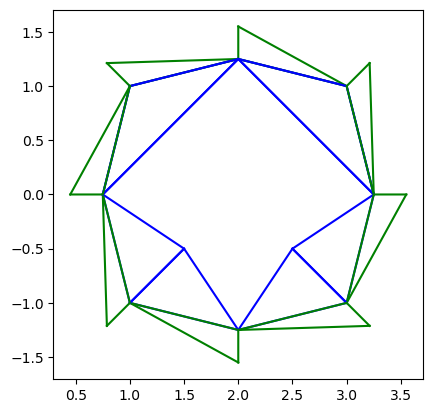

In [36]:

for i in range(0,Nwall):
    plt.plot(rz[conn[walltris[i,0],:],0],rz[conn[walltris[i,0],:],1],"-b")
    plt.plot(rz[conn[walltris[i,0],[0,2]],0],rz[conn[walltris[i,0],[0,2]],1],"-b")
    plt.plot(rz[conn[walltris[i,1],:],0],rz[conn[walltris[i,1],:],1],"-g")
    plt.plot(rz[conn[walltris[i,1],[0,2]],0],rz[conn[walltris[i,1],[0,2]],1],"-g")
plt.gca().set_aspect("equal")


In [37]:
import netCDF4 as nc
d = nc.Dataset("geometry.nc", "w", format="NETCDF4_CLASSIC")
vector = d.createDimension("vector",3)
string = d.createDimension("string",300)
cell_info_ind = d.createDimension("cell_info_ind",4)
cell_ind = d.createDimension("cell_ind",ncells+1)
surface_ind = d.createDimension("surface_ind",Nsurf_tot)
boundary_ind = d.createDimension("boundary_ind",nboundaries)
neighbor_ind = d.createDimension("neighbor_ind",nneighbors+1)
neg_pos = d.createDimension("neg_pos",2)
surface_info_ind = d.createDimension("surface_info_ind",2)
surface_tx_ind = d.createDimension("surface_tx_ind",2)
tx_ind_1 = d.createDimension("tx_ind_1",3)
tx_ind_2 = d.createDimension("tx_ind_2",4)
transform_ind = d.createDimension("transform_ind",1)
coeff_ind = d.createDimension("coeff_ind",10)
zone_type_ind = d.createDimension("zone_type_ind",4)
zone_index_ind = d.createDimension("zone_index_ind",4)
zone_ind = d.createDimension("zone_ind",Nplasma+1)
sector_ind = d.createDimension("sector_ind",2*Nwall+1)
sector_neg_pos_ind = d.createDimension("sector_neg_pos_ind",2)
sector_type_ind = d.createDimension("sector_type_ind",17)
vacuum_ind = d.createDimension("vacuum_ind",1)
plasma_ind = d.createDimension("plasma_ind",Nwall+1)
target_ind = d.createDimension("target_ind",Nwall+1)
wall_ind = d.createDimension("wall_ind",1)
exit_ind = d.createDimension("exit_ind",1)
sc_diag_name_string = d.createDimension("sc_diag_name_string",40)
diag_grp_ind = d.createDimension("diag_grp_ind",4)
sc_diag_ind = d.createDimension("sc_diag_ind",3*Nwall)
de_symbol_string = d.createDimension("de_symbol_string",24)
de_name_string = d.createDimension("de_name_string",100)
de_grp_ind = d.createDimension("de_grp_ind",1)
de_zone_frags_ind = d.createDimension("de_zone_frags_ind",100)
de_tot_view_ind = d.createDimension("de_tot_view_ind",1)
de_start_end_ind = d.createDimension("de_start_end_ind",2)
de_view_ind = d.createDimension("de_view_ind",1)

In [38]:
ncells_var = d.createVariable("ncells","i4")
nsurfaces_var = d.createVariable("nsurfaces","i4")
nboundaries_var = d.createVariable("nboundaries","i4")
nneighbors_var = d.createVariable("nneighbors","i4")
ntransforms_var = d.createVariable("ntransforms","i4")
geometry_symmetry_var = d.createVariable("geometry_symmetry","i4")
universal_cell_min_var = d.createVariable("universal_cell_min","f8",("vector",))
universal_cell_max_var = d.createVariable("universal_cell_max","f8",("vector",))
universal_cell_vol_var = d.createVariable("universal_cell_vol","f8")
cells_var = d.createVariable("cells","i4",("cell_ind","cell_info_ind",))
surfaces_var = d.createVariable("surfaces","i4",("surface_ind","surface_info_ind","neg_pos",))
surfaces_tx_ind_var = d.createVariable("surfaces_tx_ind","i4",("surface_ind","surface_tx_ind","neg_pos",))
surfaces_tx_mx_var = d.createVariable("surfaces_tx_mx","f8",("transform_ind","tx_ind_2","tx_ind_1",))
surface_sectors_var = d.createVariable("surface_sectors","i4",("surface_ind","surface_info_ind","neg_pos",))
boundaries_var = d.createVariable("boundaries","i4",("boundary_ind",))
neighbors_var = d.createVariable("neighbors","i4",("neighbor_ind",))
surface_coeffs_var = d.createVariable("surface_coeffs","f8",("surface_ind","coeff_ind",))
surface_points_var = d.createVariable("surface_points","f8",("surface_ind","neg_pos","vector",))
zn_num_var = d.createVariable("zn_num","i4")
zone_type_num_var=d.createVariable("zone_type_num","i4",("zone_type_ind",)) 
zone_type_var=d.createVariable("zone_type","i4",("zone_ind",)) 
zone_index_var=d.createVariable("zone_index","i4",("zone_ind", "zone_index_ind",)) 
zone_index_min_var=d.createVariable("zone_index_min","i4",("zone_index_ind",)) 
zone_index_max_var=d.createVariable("zone_index_max","i4",("zone_index_ind",)) 
zone_pointer_var=d.createVariable("zone_pointer","i4",("zone_ind",)) 
zone_volume_var=d.createVariable("zone_volume","f8",("zone_ind",)) 
zone_center_var=d.createVariable("zone_center","f8",("zone_ind", "vector",)) 
zone_min_var=d.createVariable("zone_min","f8",("zone_ind", "vector",)) 
zone_max_var=d.createVariable("zone_max","f8",("zone_ind", "vector",)) 
nsectors_var=d.createVariable("nsectors","i4")
strata_var=d.createVariable("strata","i4",("sector_ind",)) 
sector_strata_segment_var=d.createVariable("sector_strata_segment","i4",("sector_ind",)) 
sectors_var=d.createVariable("sectors","i4",("sector_ind",)) 
sector_zone_var=d.createVariable("sector_zone","i4",("sector_ind",)) 
sector_surface_var=d.createVariable("sector_surface","i4",("sector_ind",)) 
sector_points_var=d.createVariable("sector_points","f8",("sector_ind", "sector_neg_pos_ind", "vector",)) 
sector_type_pointer_var=d.createVariable("sector_type_pointer","i4",("sector_ind", "sector_type_ind",)) 
sc_vacuum_num_var=d.createVariable("sc_vacuum_num","i4")
vacuum_sector_var=d.createVariable("vacuum_sector","i4",("vacuum_ind",)) 
sc_plasma_num_var=d.createVariable("sc_plasma_num","i4")
plasma_sector_var=d.createVariable("plasma_sector","i4",("plasma_ind",)) 
sc_target_num_var=d.createVariable("sc_target_num","i4")
target_sector_var=d.createVariable("target_sector","i4",("target_ind",)) 
target_material_var=d.createVariable("target_material","i4",("target_ind",)) 
target_temperature_var=d.createVariable("target_temperature","f8",("target_ind",)) 
target_recyc_coef_var=d.createVariable("target_recyc_coef","f8",("target_ind",)) 
sc_wall_num_var=d.createVariable("sc_wall_num","i4")
wall_sector_var=d.createVariable("wall_sector","i4",("wall_ind",)) 
wall_material_var=d.createVariable("wall_material","i4",("wall_ind",)) 
wall_temperature_var=d.createVariable("wall_temperature","f8",("wall_ind",)) 
wall_recyc_coef_var=d.createVariable("wall_recyc_coef","f8",("wall_ind",)) 
sc_exit_num_var=d.createVariable("sc_exit_num","i4")
exit_sector_var=d.createVariable("exit_sector","i4",("exit_ind",)) 
sc_diagnostic_grps_var=d.createVariable("sc_diagnostic_grps","i4")
sc_diag_max_bins_var=d.createVariable("sc_diag_max_bins","i4")
diagnostic_grp_name_var = d.createVariable("diagnostic_grp_name","c",("diag_grp_ind","sc_diag_name_string",))
diagnostic_num_sectors_var=d.createVariable("diagnostic_num_sectors","i4",("diag_grp_ind",)) 
diagnostic_var_var=d.createVariable("diagnostic_var","i4",("diag_grp_ind",)) 
diagnostic_tab_index_var=d.createVariable("diagnostic_tab_index","i4",("diag_grp_ind",)) 
diagnostic_min_var=d.createVariable("diagnostic_min","f8",("diag_grp_ind",)) 
diagnostic_delta_var=d.createVariable("diagnostic_delta","f8",("diag_grp_ind",)) 
diagnostic_spacing_var=d.createVariable("diagnostic_spacing","i4",("diag_grp_ind",)) 
diagnostic_grp_base_var=d.createVariable("diagnostic_grp_base","i4",("diag_grp_ind",)) 
sc_diag_size_var=d.createVariable("sc_diag_size","i4")
diagnostic_sector_tab_var=d.createVariable("diagnostic_sector_tab","i4",("sc_diag_ind",)) 
de_grps_var=d.createVariable("de_grps","i4")
de_max_bins_var=d.createVariable("de_max_bins","i4")
de_zone_frags_dim_var=d.createVariable("de_zone_frags_dim","i4")
de_zone_frags_size_var=d.createVariable("de_zone_frags_size","i4")
detector_name_var = d.createVariable("detector_name","c",("de_grp_ind","de_name_string",))
detector_num_views_var=d.createVariable("detector_num_views","i4",("de_grp_ind",)) 
detector_var_var=d.createVariable("detector_var","i4",("de_grp_ind",)) 
detector_tab_index_var=d.createVariable("detector_tab_index","i4",("de_grp_ind",)) 
detector_min_var=d.createVariable("detector_min","f8",("de_grp_ind",)) 
detector_delta_var=d.createVariable("detector_delta","f8",("de_grp_ind",)) 
detector_spacing_var=d.createVariable("detector_spacing","i4",("de_grp_ind",)) 
detector_total_views_var=d.createVariable("detector_total_views","i4")
de_view_points_var=d.createVariable("de_view_points","f8",("de_tot_view_ind", "de_start_end_ind", "vector",)) 
de_view_algorithm_var=d.createVariable("de_view_algorithm","i4",("de_tot_view_ind",)) 
de_view_halfwidth_var=d.createVariable("de_view_halfwidth","f8",("de_tot_view_ind",)) 
de_zone_frags_var=d.createVariable("de_zone_frags","f8",("de_zone_frags_ind",)) 
de_zone_frags_start_var=d.createVariable("de_zone_frags_start","i4",("de_tot_view_ind",)) 
de_zone_frags_num_var=d.createVariable("de_zone_frags_num","i4",("de_tot_view_ind",)) 
de_zone_frags_zones_var=d.createVariable("de_zone_frags_zones","i4",("de_zone_frags_ind",)) 
de_zone_frags_min_zn_var=d.createVariable("de_zone_frags_min_zn","i4",("de_tot_view_ind",)) 
de_zone_frags_max_zn_var=d.createVariable("de_zone_frags_max_zn","i4",("de_tot_view_ind",)) 
de_view_base_var=d.createVariable("de_view_base","i4",("de_grp_ind",)) 
de_view_size_var=d.createVariable("de_view_size","i4")
de_view_tab_var=d.createVariable("de_view_tab","i4",("de_view_ind",))



In [39]:
ncells_var[:] = ncells
nsurfaces_var[:] = nsurfaces
nboundaries_var[:] = [nboundaries]
nneighbors_var[:] = nneighbors
ntransforms_var[:] = ntransforms
geometry_symmetry_var[:] = geometry_symmetry
universal_cell_min_var[:] = universal_cell_min
universal_cell_max_var[:] = universal_cell_max
universal_cell_vol_var[:] = universal_cell_vol
cells_var[:] = cells
surfaces_var[:] = surfaces
surfaces_tx_ind_var[:] = surfaces_tx_ind
surfaces_tx_mx_var[:] = surfaces_tx_mx
surface_sectors_var[:] = surface_sectors
boundaries_var[:] = boundaries
neighbors_var[:] = neighbors
surface_coeffs_var[:] = surface_coeffs
surface_points_var[:] = surface_points
zn_num_var[:] = zn_num
zone_type_num_var[:] = zone_type_num
zone_type_var[:] = zone_type
zone_index_var[:] = zone_index
zone_index_min_var[:] = zone_index_min
zone_index_max_var[:] = zone_index_max
zone_pointer_var[:] = zone_pointer
zone_volume_var[:] = zone_volume
zone_center_var[:] = zone_center
zone_min_var[:] = zone_min
zone_max_var[:] = zone_max
nsectors_var[:] = nsectors
strata_var[:] = strata
sector_strata_segment_var[:] = sector_strata_segment
sectors_var[:] = sectors
sector_zone_var[:] = sector_zone
sector_surface_var[:] = sector_surface
sector_points_var[:] = sector_points
sector_type_pointer_var[:] = sector_type_pointer
sc_vacuum_num_var[:] = sc_vacuum_num
vacuum_sector_var[:] = vacuum_sector
sc_plasma_num_var[:] = sc_plasma_num
plasma_sector_var[:] = plasma_sector
sc_target_num_var[:] = sc_target_num
target_sector_var[:] = target_sector
target_material_var[:] = target_material
target_temperature_var[:] = target_temperature
target_recyc_coef_var[:] = target_recyc_coef
sc_wall_num_var[:] = sc_wall_num
wall_sector_var[:] = wall_sector
wall_material_var[:] = wall_material
wall_temperature_var[:] = wall_temperature
wall_recyc_coef_var[:] = wall_recyc_coef
sc_exit_num_var[:] = sc_exit_num
exit_sector_var[:] = exit_sector
sc_diagnostic_grps_var[:] = sc_diagnostic_grps
sc_diag_max_bins_var[:] = sc_diag_max_bins
diagnostic_num_sectors_var[:] = diagnostic_num_sectors
diagnostic_var_var[:] = diagnostic_var
diagnostic_tab_index_var[:] = diagnostic_tab_index
diagnostic_min_var[:] = diagnostic_min
diagnostic_delta_var[:] = diagnostic_delta
diagnostic_spacing_var[:] = diagnostic_spacing
diagnostic_grp_base_var[:] = diagnostic_grp_base
sc_diag_size_var[:] = sc_diag_size
diagnostic_sector_tab_var[:] = diagnostic_sector_tab
de_grps_var[:] = de_grps
de_max_bins_var[:] = de_max_bins
de_zone_frags_dim_var[:] = de_zone_frags_dim
de_zone_frags_size_var[:] = de_zone_frags_size
detector_num_views_var[:] = detector_num_views
detector_var_var[:] = detector_var
detector_tab_index_var[:] = detector_tab_index
detector_min_var[:] = detector_min
detector_delta_var[:] = detector_delta
detector_spacing_var[:] = detector_spacing
detector_total_views_var[:] = detector_total_views
de_view_points_var[:] = de_view_points
de_view_algorithm_var[:] = de_view_algorithm
de_view_halfwidth_var[:] = de_view_halfwidth
de_zone_frags_var[:] = de_zone_frags
de_zone_frags_start_var[:] = de_zone_frags_start
de_zone_frags_num_var[:] = de_zone_frags_num
de_zone_frags_zones_var[:] = de_zone_frags_zones
de_zone_frags_min_zn_var[:] = de_zone_frags_min_zn
de_zone_frags_max_zn_var[:] = de_zone_frags_max_zn
de_view_base_var[:] = de_view_base
de_view_size_var[:] = de_view_size
de_view_tab_var[:] = de_view_tab

In [40]:
diagnostic_grp_name_var[0,:] = "UNUSED                                  "
diagnostic_grp_name_var[1,:] = "Wall and Target Counts                  "
diagnostic_grp_name_var[2,:] = "Wall and Target Energy Spectrum         "
diagnostic_grp_name_var[3,:] = "Wall and Target Angle Spectrum          "
detector_name_var[:] = "UNUSED                                                                                              "

In [41]:
d.close()

In [42]:
ncells

44

In [43]:
Ntri

28